In [1]:
from coffee_src import MysqlConnector
import seaborn as sns
import pandas as pd
import requests 
from io import BytesIO
from zipfile import ZipFile
import geopandas
import matplotlib.pyplot as plt

# SQL Connection!

In [3]:
sql = MysqlConnector()

# USDA's data

In [63]:
resp = requests.get('https://apps.fas.usda.gov/psdonline/downloads/psd_coffee_csv.zip')
with ZipFile(BytesIO(resp.content)) as z:
    usda = pd.read_csv(z.open('psd_coffee.csv'))
usda.head()

,Commodity_Code,Commodity_Description,Country_Code,Country_Name,Market_Year,Calendar_Year,Month,Attribute_ID,Attribute_Description,Unit_ID,Unit_Description,Value
0,711100,"Coffee, Green",AG,Algeria,2003,2012,6,29,Arabica Production,2,(1000 60 KG BAGS),0.0
1,711100,"Coffee, Green",AG,Algeria,2003,2012,6,90,Bean Exports,2,(1000 60 KG BAGS),0.0
2,711100,"Coffee, Green",AG,Algeria,2003,2012,6,58,Bean Imports,2,(1000 60 KG BAGS),1800.0
3,711100,"Coffee, Green",AG,Algeria,2003,2012,6,20,Beginning Stocks,2,(1000 60 KG BAGS),0.0
4,711100,"Coffee, Green",AG,Algeria,2003,2012,6,125,Domestic Consumption,2,(1000 60 KG BAGS),1805.0


# Create Schema

In [ ]:
cmds = """
    SET FOREIGN_KEY_CHECKS = 0; 
    DROP TABLE IF EXISTS country CASCADE; 
    DROP TABLE IF EXISTS trade CASCADE;
    DROP TABLE IF EXISTS has_trade CASCADE;
    SET FOREIGN_KEY_CHECKS = 1; 

    CREATE TABLE IF NOT EXISTS country(
        code VARCHAR(2) NOT NULL,
        name VARCHAR(255) NOT NULL,
        PRIMARY KEY (code)
    );

    CREATE TABLE IF NOT EXISTS trade(
        id INT NOT NULL,
        type TEXT NOT NULL,
        PRIMARY KEY (id)
    );

    CREATE TABLE IF NOT EXISTS has_trade(
        year VARCHAR(4) NOT NULL,
        trade_id INT NOT NULL,
        country_code VARCHAR(2) NOT NULL,
        value INT NOT NULL,
        PRIMARY KEY (country_code, trade_id, year),
        FOREIGN KEY (trade_id) REFERENCES trade (id) ON  DELETE CASCADE ON UPDATE CASCADE,
        FOREIGN KEY (country_code) REFERENCES country (code) ON  DELETE CASCADE ON UPDATE CASCADE
    );
"""
cmds = [cmd.strip() for cmd in cmds.split(';')]
for cmd in cmds:
    resp_code, resp = sql.post(cmd)
    if resp_code != 1: print(cmd)

# Populate database

In [61]:
def insert_country(row):
    cmd = f'insert into country (code, name) values ("{row.Country_Code}", "{row.Country_Name}")'
    resp_code, resp = sql.post(cmd)
    if resp_code != 1: print(cmd)

def insert_trade(row):
    cmd = f'insert into trade (id, type) values ({row.Attribute_ID}, "{row.Attribute_Description}")'
    resp_code, resp = sql.post(cmd)
    if resp_code != 1: print(cmd)
        
def insert_has_trade(row):
    cmd = f'insert into has_trade (country_code, year, trade_id, value) values ("{row.Country_Code}", "{row.Market_Year}", {row.Attribute_ID}, {row.Value})'
    resp_code, resp = sql.post(cmd)
    if resp_code != 1: print(cmd)

for row in usda[['Country_Code', 'Country_Name']].drop_duplicates().itertuples():
    insert_country(row)

for row in usda[['Attribute_ID', 'Attribute_Description']].drop_duplicates().itertuples():
    insert_trade(row)

metrics =  [
    'Imports',
    'Exports',
    'Domestic Consumption',
    'Arabica Production',
    'Robusta Production',
    'Other Production',
]
for row in usda[['Country_Code', 'Market_Year', 'Attribute_ID', 'Value']][usda.Attribute_Description.isin(metrics)].itertuples():
    insert_has_trade(row)

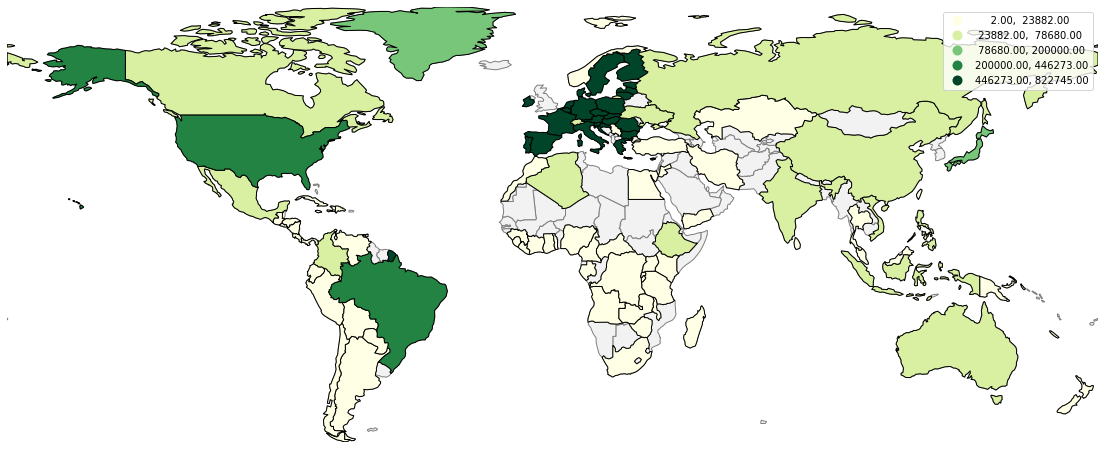

In [20]:
def attribute_query(attribute):
    code, df = sql.get('select * from trade, has_trade, country '
                       'where has_trade.trade_id = trade.id and country.code = has_trade.country_code')
    df = df[df.type==attribute]
    df = df.pivot(index='name', columns='year', values='value')
    df = df.fillna(0)
    return df

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map = world[world.name != 'Antarctica']
world_map = world_map[['name', 'geometry']]
world_map.set_index('name', inplace=True)

fig, ax = plt.subplots(figsize=(20,8))
ax.set_aspect('equal')
ax.margins(0)
ax.axis('off')
world_map.plot(color='#f2f2f2', edgecolor="Grey", ax=ax)

world_production = attribute_query('Domestic Consumption')
world_production.fillna(0,inplace=True)
world_production = world_production.iloc[:,-25:]

european_union = [
    'Austria',
    'Italy',
    'Belgium',
    'Latvia',
    'Bulgaria',
    'Lithuania',
    'Croatia',
    'Luxembourg',
    'Cyprus',
    'Malta',
    'Czechia',
    'Netherlands',
    'Denmark',
    'Poland',
    'Estonia',
    'Portugal',
    'Finland',
    'Romania',
    'France',
    'Slovakia',
    'Germany',
    'Slovenia',
    'Greece',
    'Spain',
    'Hungary',
    'Sweden',
    'Ireland',
]

for eu in european_union:
    world_production.loc[eu] = world_production.loc['European Union']

world_production.rename({
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Central African Republic": "Central African Rep.",
    "Congo (Kinshasa)": "Dem. Rep. Congo",
    "Dominican Republic": "Dominican Rep.",
    "United States": "United States of America",
    "Laos": "Lao PDR",
}, inplace=True)

def cagr(series):
    start_val = series.iloc[0]
    if not start_val:
        return None
    end_val = series.iloc[-1]
    num_vals = len(series)
    CAGR = (end_val/start_val)**(1/num_vals)-1
    return CAGR

# world_production['CAGR'] = world_production.apply(cagr, axis=1)
world_production['CAGR'] = world_production.apply(sum, axis=1)

world_production.dropna(inplace=True)
world_production = world_production[world_production.CAGR != -1]

cagr_map = pd.concat([world_map, world_production], axis=1, sort=True)
cagr_map.update(cagr_map[cagr_map.columns[1:]].fillna(0))
# cagr_map.plot(column='CAGR', ax=ax, legend=True)

growing_map = cagr_map[cagr_map.CAGR > 0]
growing_map.plot(column='CAGR', cmap='YlGn', scheme='fisher_jenks', edgecolor='black', ax=ax, legend=True)

plt.savefig('map.png')

<AxesSubplot:xlabel='Market_Year', ylabel='Value'>

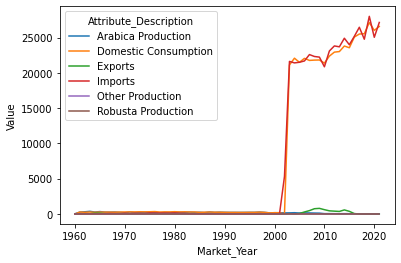

In [7]:
def get_lineplot(country_name):
    metrics =  [
        'Imports',
        'Exports',
        'Domestic Consumption',
        'Arabica Production',
        'Robusta Production',
        'Other Production',
    ]
    df = usda[usda.Country_Name == country_name]
    return sns.lineplot(data=df[df.Attribute_Description.isin(metrics)], y='Value', x='Market_Year', hue='Attribute_Description')

get_lineplot('United States')

In [65]:
def attribute_query(attribute: str, countries: list = None) -> pd.DataFrame:
    df = usda[usda.Attribute_Description == attribute]
    if countries:
        df = df[df.Country_Name.isin(countries)]
    return df.pivot(
      index='Country_Name', 
      columns='Market_Year', 
      values='Value'
    )

attribute_query('Production')

Market_Year,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country_Name,,,,,,,,,,,,,,,,,,,,,
Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,NaN,2500.0,2800.0,2500.0,2691.0,2487.0,3057.0,3691.0,3458.0,3525.0,...,35.0,29.0,31.0,30.0,25.0,20.0,19.0,20.0,20.0,20.0
Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Benin,NaN,36.0,30.0,18.0,20.0,12.0,11.0,18.0,7.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,NaN,76.0,66.0,66.0,60.0,66.0,76.0,86.0,66.0,66.0,...,26000.0,26500.0,29833.0,27400.0,28930.0,26700.0,29300.0,30400.0,31300.0,29000.0
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,135.0,140.0,135.0,130.0,130.0,125.0,125.0,125.0,100.0,100.0
Yemen (Sanaa),NaN,90.0,90.0,82.0,80.0,90.0,75.0,60.0,60.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


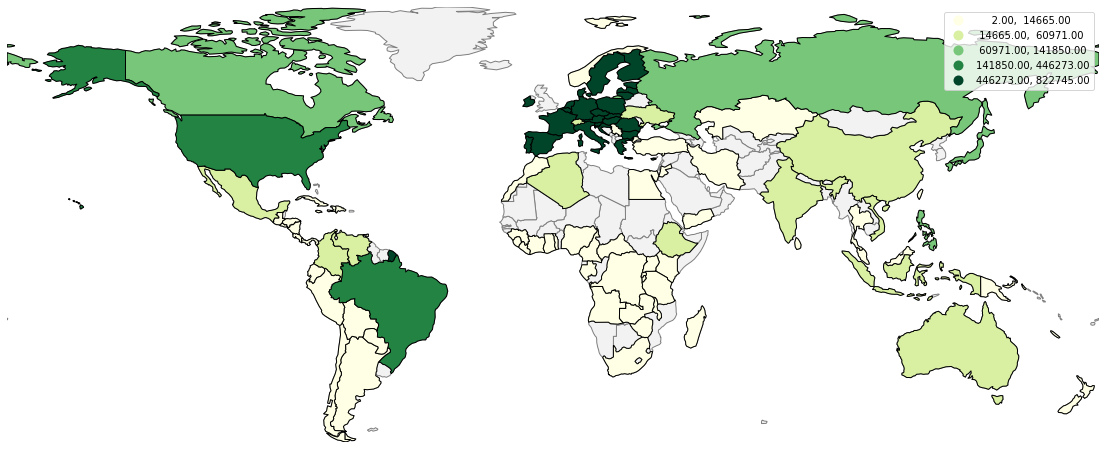

In [85]:

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map = world[world.name != 'Antarctica']
world_map = world_map[['name', 'geometry']]
world_map.set_index('name', inplace=True)

fig, ax = plt.subplots(figsize=(20,8))
ax.set_aspect('equal')
ax.margins(0)
ax.axis('off')
world_map.plot(color='#f2f2f2', edgecolor="Grey", ax=ax)

world_production = attribute_query('Domestic Consumption')
world_production.fillna(0,inplace=True)
world_production = world_production.iloc[:,-25:]

european_union = [
    'Austria',
    'Italy',
    'Belgium',
    'Latvia',
    'Bulgaria',
    'Lithuania',
    'Croatia',
    'Luxembourg',
    'Cyprus',
    'Malta',
    'Czechia',
    'Netherlands',
    'Denmark',
    'Poland',
    'Estonia',
    'Portugal',
    'Finland',
    'Romania',
    'France',
    'Slovakia',
    'Germany',
    'Slovenia',
    'Greece',
    'Spain',
    'Hungary',
    'Sweden',
    'Ireland',
]

for eu in european_union:
    world_production.loc[eu] = world_production.loc['European Union']

world_production.rename({
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Central African Republic": "Central African Rep.",
    "Congo (Kinshasa)": "Dem. Rep. Congo",
    "Dominican Republic": "Dominican Rep.",
    "United States": "United States of America",
    "Laos": "Lao PDR",
}, inplace=True)

def cagr(series):
    start_val = series.iloc[0]
    if not start_val:
        return None
    end_val = series.iloc[-1]
    num_vals = len(series)
    CAGR = (end_val/start_val)**(1/num_vals)-1
    return CAGR

# world_production['CAGR'] = world_production.apply(cagr, axis=1)
world_production['CAGR'] = world_production.apply(sum, axis=1)

world_production.dropna(inplace=True)
world_production = world_production[world_production.CAGR != -1]

cagr_map = pd.concat([world_map, world_production], axis=1, sort=True)
cagr_map.update(cagr_map[cagr_map.columns[1:]].fillna(0))
# cagr_map.plot(column='CAGR', ax=ax, legend=True)

growing_map = cagr_map[cagr_map.CAGR > 0]
growing_map.plot(column='CAGR', cmap='YlGn', scheme='fisher_jenks', edgecolor='black', ax=ax, legend=True)

plt.savefig('map.png')
# shrinking_map = cagr_map[cagr_map.CAGR < 0]
# shrinking_map.plot(column='CAGR', cmap='Reds_r', scheme='fisher_jenks', edgecolor='black', ax=ax)

# fig
# ax.set_ylim([-23.5,23.5])
# ax.set_xlim([-120,160])

In [71]:
plt.savefig('')

AttributeError: 'GeoDataFrame' object has no attribute 'fig'

<AxesSubplot:>

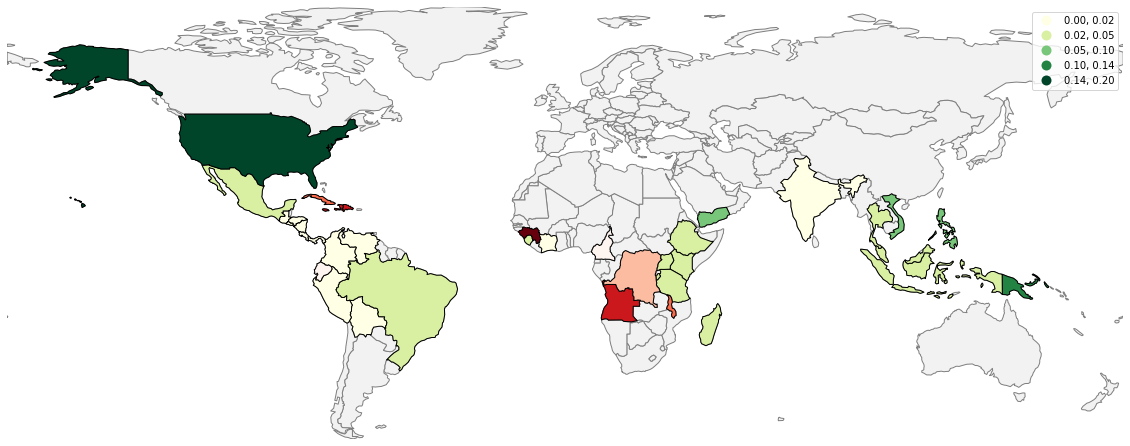

In [70]:
import geopandas
import matplotlib.pyplot as plt

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world_map = world[world.name != 'Antarctica']
world_map = world_map[['name', 'geometry']]
world_map.set_index('name', inplace=True)

fig, ax = plt.subplots(figsize=(20,8))
ax.set_aspect('equal')
ax.margins(0)
ax.axis('off')
world_map.plot(color='#f2f2f2', edgecolor="Grey", ax=ax)

world_production = attribute_query('Domestic Consumption')
world_production.fillna(0,inplace=True)
world_production = world_production.iloc[:,-25:]

european_union = [
    'Austria',
    'Italy',
    'Belgium',
    'Latvia',
    'Bulgaria',
    'Lithuania',
    'Croatia',
    'Luxembourg',
    'Cyprus',
    'Malta',
    'Czechia',
    'Netherlands',
    'Denmark',
    'Poland',
    'Estonia',
    'Portugal',
    'Finland',
    'Romania',
    'France',
    'Slovakia',
    'Germany',
    'Slovenia',
    'Greece',
    'Spain',
    'Hungary',
    'Sweden',
    'Ireland',
]
for eu in european_union:
    world_production.loc[eu] = world_production.loc['European Union']

world_production.rename({
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Central African Republic": "Central African Rep.",
    "Congo (Kinshasa)": "Dem. Rep. Congo",
    "Dominican Republic": "Dominican Rep.",
    "United States": "United States of America",
    "Laos": "Lao PDR",
}, inplace=True)

def cagr(series):
    start_val = series.iloc[0]
    if not start_val:
        return None
    end_val = series.iloc[-1]
    num_vals = len(series)
    CAGR = (end_val/start_val)**(1/num_vals)-1
    return CAGR

world_production['CAGR'] = world_production.apply(cagr, axis=1)
# world_production['CAGR'] = world_production.apply(sum, axis=1)

world_production.dropna(inplace=True)
world_production = world_production[world_production.CAGR != -1]

cagr_map = pd.concat([world_map, world_production], axis=1, sort=True)
cagr_map.update(cagr_map[cagr_map.columns[1:]].fillna(0))
# cagr_map.plot(column='CAGR', ax=ax, legend=True)

growing_map = cagr_map[cagr_map.CAGR > 0]
growing_map.plot(column='CAGR', cmap='YlGn', scheme='fisher_jenks', edgecolor='black', ax=ax, legend=True)

shrinking_map = cagr_map[cagr_map.CAGR < 0]
shrinking_map.plot(column='CAGR', cmap='Reds_r', scheme='fisher_jenks', edgecolor='black', ax=ax)

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


In [13]:
sorted(world_map.index)

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herz.',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Rep.',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 "Côte d'Ivoire",
 'Dem. Rep. Congo',
 'Denmark',
 'Djibouti',
 'Dominican Rep.',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eq. Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Falkland Is.',
 'Fiji',
 'Finland',
 'Fr. S. Antarctic Lands',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',


In [55]:
world_production.loc['Austria'] = world_production.loc['European Union']

In [38]:
set(usda['Country_Name']) - set(world_map.index)

{'Central African Republic',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 "Cote d'Ivoire",
 'Dominican Republic',
 'Equatorial Guinea',
 'European Union',
 'Korea, South',
 'Singapore',
 'United States',
 'Yemen (Sanaa)'}